# Loan Approval using Stochastic Gradient Descent

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("2018_hmda_processed.csv")

In [3]:
df = df.drop(columns=['applicant_age_above_62', 'reverse_mortgage', 'open_end_line_of_credit']) # redundant data that is causing type error

In [4]:
df.columns

Index(['Unnamed: 0', 'activity_year', 'county_code', 'census_tract',
       'conforming_loan_limit', 'action_taken', 'preapproval', 'loan_purpose',
       'business_or_commercial_purpose', 'loan_amount', 'interest_rate',
       'hoepa_status', 'loan_term', 'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units', 'income',
       'applicant_credit_score_type', 'applicant_sex', 'applicant_age',
       'submission_of_application', 'initially_payable_to_institution',
       'tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
       'tract_median_age_of_housing_units', 'has_co_applicant', 'dti', 'race',
       'ethnicity', 'loan_value_ratio', 'credit history',
    

## Stochastic Gradient Descent

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [6]:
# -------------------------------
# 1. Load and Prepare Your Data
# -------------------------------

# Assume your DataFrame is called `df` and has:
# - features in df[feature_cols]
# - target column: 'loan_approved'
# - protected group column: 'derived_race' or 'applicant_sex'

feature_cols = ['conforming_loan_limit', 'preapproval', 'loan_purpose',
       'business_or_commercial_purpose', 'loan_amount', 'interest_rate',
       'hoepa_status', 'loan_term', 'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units', 'income',
       'applicant_credit_score_type', 'submission_of_application', 'initially_payable_to_institution',
       'has_co_applicant', 'dti', 'race', 'ethnicity', 'loan_value_ratio', 'credit history',
       'employment history']  # your selected features
target_col = 'action_taken'
group_col = 'race'  # or 'applicant_sex'
privileged_value = 1.0  # or 'Male'

X = df[feature_cols]
y = df[target_col]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# -------------------------------
# 2. Train SGDClassifier
# -------------------------------

sgd_model = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=42)
sgd_model.fit(X_train_scaled, y_train)

# Get decision function scores for thresholding
scores = sgd_model.decision_function(X_test_scaled)


--- Percentile 50% (Threshold = 32.43) ---
Precision: 1.0000, Recall: 0.5952, F1: 0.7463
Demographic Parity Difference: -0.0306
Disparate Impact Ratio: 0.9414

--- Percentile 60% (Threshold = 32.65) ---
Precision: 1.0000, Recall: 0.4762, F1: 0.6451
Demographic Parity Difference: -0.0351
Disparate Impact Ratio: 0.9176

--- Percentile 70% (Threshold = 32.92) ---
Precision: 1.0000, Recall: 0.3571, F1: 0.5263
Demographic Parity Difference: -0.0369
Disparate Impact Ratio: 0.8873

--- Percentile 80% (Threshold = 33.24) ---
Precision: 1.0000, Recall: 0.2381, F1: 0.3846
Demographic Parity Difference: -0.0323
Disparate Impact Ratio: 0.8561

--- Percentile 90% (Threshold = 33.60) ---
Precision: 1.0000, Recall: 0.1190, F1: 0.2128
Demographic Parity Difference: -0.0174
Disparate Impact Ratio: 0.8459


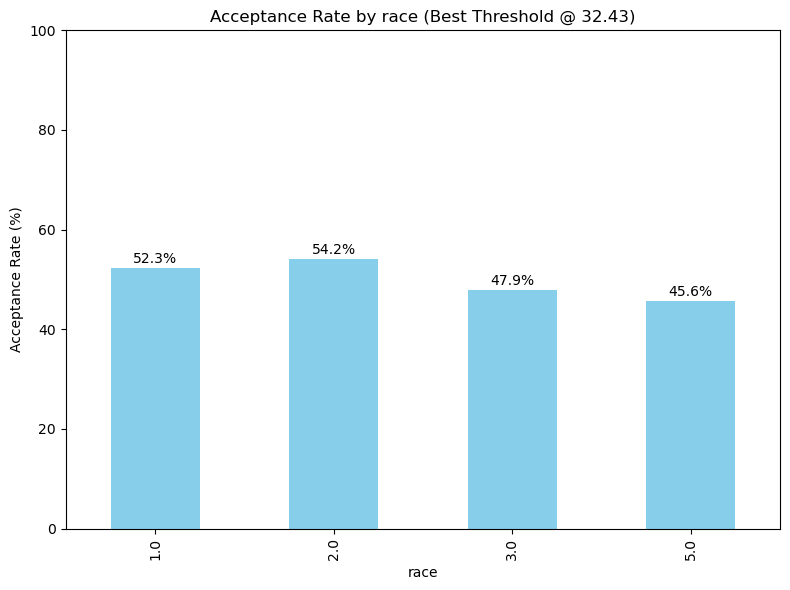

In [8]:
# -------------------------------
# 3. Evaluate Thresholds + Fairness
# -------------------------------

def evaluate_threshold(
    scores, y_true, df_test, group_col, privileged_value, percentiles=[50, 60, 70, 80, 90]
):
    best_f1 = 0
    best_thresh = None
    best_preds = None

    for p in percentiles:
        thresh = np.percentile(scores, p)
        preds = (scores > thresh).astype(int)

        report = classification_report(y_true, preds, output_dict=True, zero_division=0)
        f1 = report['1']['f1-score']
        print(f"\n--- Percentile {p}% (Threshold = {thresh:.2f}) ---")
        print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1: {f1:.4f}")

        df_temp = df_test.reset_index(drop=True).copy()
        df_temp['predicted'] = preds

        # Fairness calculations
        privileged_rate = df_temp[df_temp[group_col] == privileged_value]['predicted'].mean()
        unprivileged_rate = df_temp[df_temp[group_col] != privileged_value]['predicted'].mean()

        dp_diff = unprivileged_rate - privileged_rate
        di_ratio = unprivileged_rate / privileged_rate if privileged_rate != 0 else np.nan

        print(f"Demographic Parity Difference: {dp_diff:.4f}")
        print(f"Disparate Impact Ratio: {di_ratio:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            best_preds = preds

    # Final plot
    df_result = df_test.copy()
    df_result['predicted'] = best_preds
    accepted_rate = df_result.groupby(group_col)['predicted'].mean() * 100

    plt.figure(figsize=(8, 6))
    accepted_rate.plot(kind="bar", color="skyblue")
    plt.title(f"Acceptance Rate by {group_col} (Best Threshold @ {best_thresh:.2f})")
    plt.ylabel("Acceptance Rate (%)")
    for i, pct in enumerate(accepted_rate):
        plt.text(i, pct + 1, f"{pct:.1f}%", ha='center')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    return best_thresh, best_f1

# Apply to the test set
df_test = df.loc[X_test.index].copy()
best_thresh, best_f1 = evaluate_threshold(
    scores=scores,
    y_true=y_test,
    df_test=df_test,
    group_col=group_col,
    privileged_value=privileged_value,
    percentiles=[50, 60, 70, 80, 90]
)



Final Evaluation Metrics
Accuracy: 0.6599828620394174
Precision: 1.0
Recall: 0.5952259512394165
F1 Score: 0.7462591124184679
ROC AUC Score: 0.99037664587791


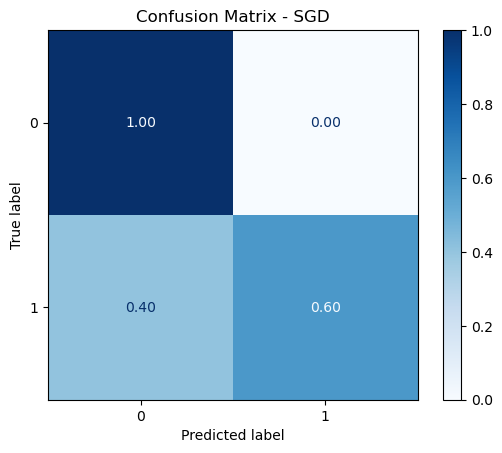

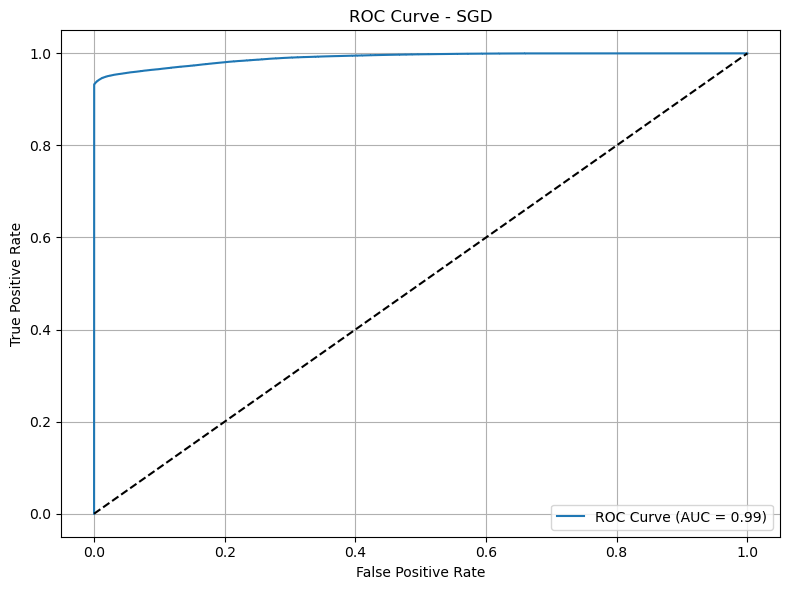

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Apply best threshold to get final predictions
final_preds = (scores > best_thresh).astype(int)

# Print classification metrics
print("\nFinal Evaluation Metrics")
print("Accuracy:", accuracy_score(y_test, final_preds))
print("Precision:", precision_score(y_test, final_preds))
print("Recall:", recall_score(y_test, final_preds))
print("F1 Score:", f1_score(y_test, final_preds))

# ROC AUC
roc_auc = roc_auc_score(y_test, scores)  # Note: use raw scores, not thresholded predictions
print("ROC AUC Score:", roc_auc)

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix - SGD")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, scores)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SGD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
